## Import modules

In [1]:
import numpy as np
import pandas as pd

from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor

from base_learners.base_analysis import get_ate, report_ate, tradeoff
from visualization.ensemble_treatment_visualization import mse_comparison, ensemble_comparison, BoxPlot

In [2]:
%store -r T
%store -r T0
%store -r senario
%store -r control_data
%store -r treat_data
%store -r untreat_data
%store -r sample_size
%store -r counter_en_dict
%store -r out_best_report
%store -r ate_hat_syn
%store -r ate_syn
%store -r ate_hat_lasso
%store -r ate_lasso
%store -r ate_hat_mdd
%store -r ate_mdd
%store -r ate_hat_mc
%store -r ate_mc
%store -r nonnegative

## Evaluate stacked regression

In [3]:
# Evaluate Mean Average Treatment Effect of ensemble methods.
select_counter_en = {}
counterfactuals_en = []
for sample in np.arange(sample_size):
    select_counter_en[f'{sample + 1}'] = {}
    select_key = list(out_best_report[f'{sample + 1}'].keys())[1]
    select_value = counter_en_dict[f'{sample + 1}'][select_key]
    
    select_counter_en[f'{sample + 1}'][select_key] = select_value
    counterfactuals_en.append(select_value)

In [4]:
ate_hat_en, ate_en = get_ate(counterfactuals_en, control_data, treat_data, untreat_data, T0)
stacking_mse, stacking_bias, stacking_var = tradeoff(ate_hat_en, ate_en, sample_size, show_mse=True)
report_ate(ate_hat_en, control_idx_list=None)

Mean of ate: 20.03924639842229
Standard deviation of ate: 0.9782502844935168
Sum of average treatment effect: 80.15698559368916
No available weights for reporting!


## Evaluate boosting and bagging

In [5]:
# Implement adaptive boosting and bagging for regression problem.
counterfactuals_ada = []
counterfactuals_bagging = []

for i in np.arange(sample_size):
    print(f'{i+1}th iteration starts')
    X_train = control_data[i].values[:, :T0].T
    y_train = treat_data[i].values.reshape(-1,)[:T0]
    X_predict = control_data[i].values[:, T0:].T
    
    ada_reg = AdaBoostRegressor(base_estimator=None, n_estimators=50, loss='exponential', learning_rate=0.6, random_state=2020)   
    ada_reg.fit(X_train, y_train)
    y_predict = ada_reg.predict(X_predict)
    counterfactuals_ada.append(y_predict)
    
    bag_reg = BaggingRegressor(base_estimator=None, n_estimators=50, random_state=2020)
    bag_reg.fit(X_train, y_train)
    y_predict = bag_reg.predict(X_predict)
    counterfactuals_bagging.append(y_predict)

1th iteration starts
2th iteration starts
3th iteration starts
4th iteration starts
5th iteration starts
6th iteration starts
7th iteration starts
8th iteration starts
9th iteration starts
10th iteration starts
11th iteration starts
12th iteration starts
13th iteration starts
14th iteration starts
15th iteration starts
16th iteration starts
17th iteration starts
18th iteration starts
19th iteration starts
20th iteration starts
21th iteration starts
22th iteration starts
23th iteration starts
24th iteration starts
25th iteration starts
26th iteration starts
27th iteration starts
28th iteration starts
29th iteration starts
30th iteration starts
31th iteration starts
32th iteration starts
33th iteration starts
34th iteration starts
35th iteration starts
36th iteration starts
37th iteration starts
38th iteration starts
39th iteration starts
40th iteration starts
41th iteration starts
42th iteration starts
43th iteration starts
44th iteration starts
45th iteration starts
46th iteration star

In [6]:
# Analysis for boosting.
ate_hat_ada, ate_ada = get_ate(counterfactuals_ada, control_data, treat_data, untreat_data, T0)
boosting_mse, boosting_bias, boosting_var = tradeoff(ate_hat_ada, ate_ada, sample_size, show_mse=True)
report_ate(ate_hat_ada, control_idx_list=None)

Mean of ate: 20.682119687221597
Standard deviation of ate: 1.5599921328766981
Sum of average treatment effect: 82.72847874888639
No available weights for reporting!


In [7]:
# Analysis for bagging
ate_hat_bag, ate_bag = get_ate(counterfactuals_bagging, control_data, treat_data, untreat_data, T0)
bagging_mse, bagging_bias, bagging_var = tradeoff(ate_hat_bag, ate_bag, sample_size, show_mse=True)
report_ate(ate_hat_bag, control_idx_list=None)

Mean of ate: 20.747089449714714
Standard deviation of ate: 1.5394956631983419
Sum of average treatment effect: 82.98835779885886
No available weights for reporting!


## Visualization

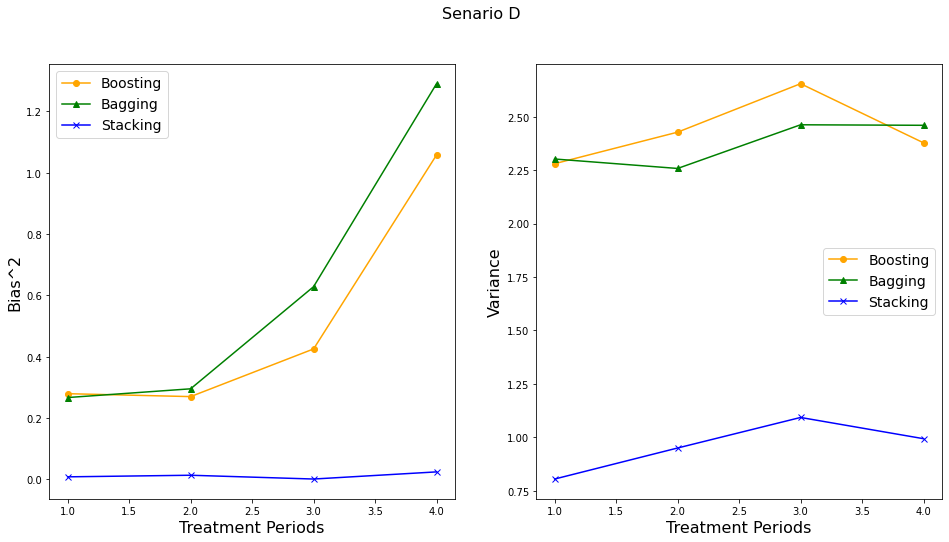

In [8]:
# Visualization 3: Compare different ensemble methods Bagging/Boosting/Stacking
ensemble_comparison(stacking_bias, stacking_var,
                   boosting_bias, boosting_var,
                   bagging_bias, bagging_var, T, T0, nonnegative, senario)

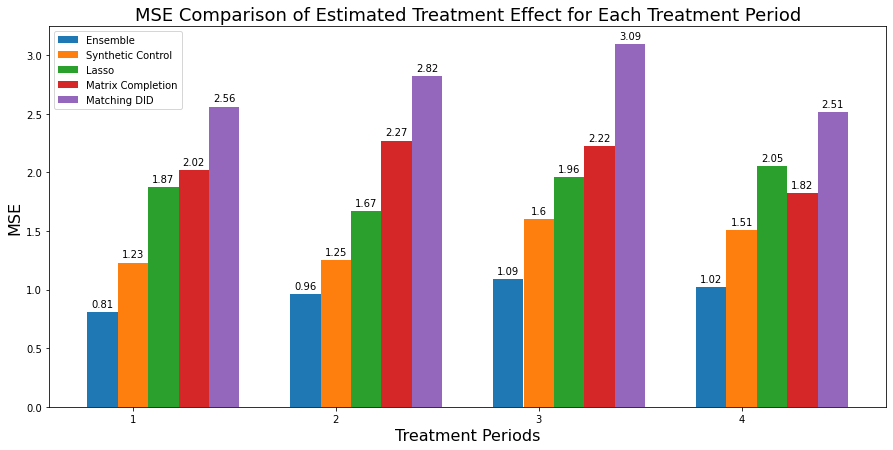

In [9]:
# Visualization 4: Based on 100 times data draw, compare stacked regression with base learners
# for each treatment period.
mse_ate_en, bias_en, var_en = tradeoff(ate_hat_en, ate_en, sample_size, show_mse=True)
mse_ate_syn, bias_syn, var_syn = tradeoff(ate_hat_syn, ate_syn, sample_size, show_mse=True)
mse_ate_lasso, bias_lasso, var_lasso = tradeoff(ate_hat_lasso, ate_lasso, sample_size, show_mse=True)
mse_ate_mc, bias_mc, var_mc = tradeoff(ate_hat_mc, ate_mc, sample_size, show_mse=True)
mse_ate_mdd, bias_mdd, var_mdd = tradeoff(ate_hat_mdd, ate_mdd, sample_size, show_mse=True)

mse_comparison(mse_ate_en, mse_ate_syn, mse_ate_lasso, mse_ate_mc, mse_ate_mdd)

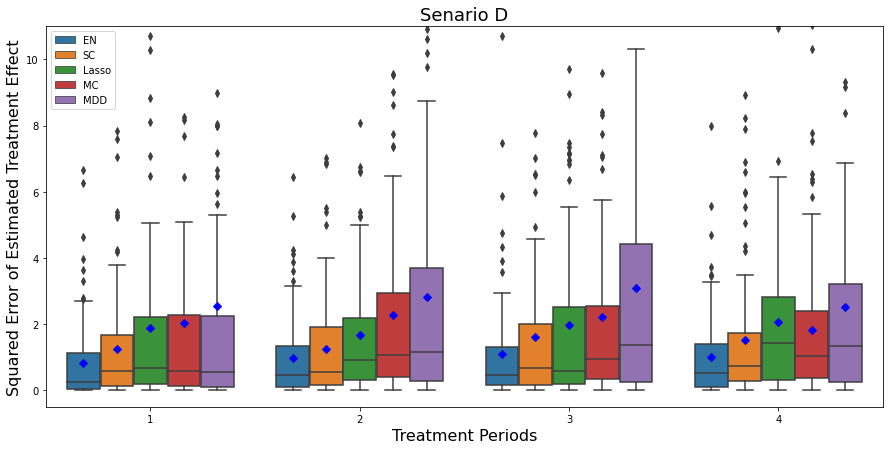

In [10]:
# Visualization 5: Boxplot for squared errors of treatment effect
model_dict = {
    'model_1': [ate_hat_en, 20, 'EN'],
    'model_2': [ate_hat_syn, 20, 'SC'],
    'model_3': [ate_hat_lasso, 20, 'Lasso'],
    'model_4': [ate_hat_mc, 20, 'MC'],
    'model_5': [ate_hat_mdd, 20, 'MDD']
}

boxplot = BoxPlot(estimation_dict=model_dict, T=T, T0=T0, nonnegative=nonnegative, senario=senario)
df_for_plot = boxplot.stack_tables()
boxplot.plot(df_for_plot)

## Generating reports

In [11]:
## Save reports
np.set_printoptions(suppress=True)

# Write reports
mean_ate_en, std_ate_en, sum_all_treat_en = report_ate(ate_hat_en, output=True)
mean_ate_syn, std_ate_syn, sum_all_treat_syn = report_ate(ate_hat_syn, output=True)
mean_ate_mc, std_ate_mc, sum_all_treat_mc = report_ate(ate_hat_mc, output=True)
mean_ate_lasso, std_ate_lasso, sum_all_treat_lasso = report_ate(ate_hat_lasso, output=True)
mean_ate_mdd, std_ate_mdd, sum_all_treat_mdd = report_ate(ate_hat_mdd, output=True)

with open('output/reports/report.txt', 'w') as text_file:
    print(f'Senario {senario}', file=text_file)
    print('', file=text_file)
    if nonnegative == True:
        print('With nonnegative constraint, leave-one-out:', file=text_file)
    else:
        print('Without nonnegative constraint, leave-one-out:', file=text_file)
        
    print('', file=text_file)
    print('Ensemble:', file=text_file)
    print('', file=text_file)
    print('Mean of ate:', mean_ate_en, file=text_file)
    print('Standard deviation of ate:', std_ate_en, file=text_file)
    print('Sum of average treatment effect:', sum_all_treat_en, file=text_file)
    print('', file=text_file)
    print('Bias^2:', bias_en, file=text_file)
    print('', file=text_file)
    print('Variance:', var_en, file=text_file)
    print('', file=text_file)
    print('MSE:', mse_ate_en, '(mean {})'.format(np.mean(mse_ate_en)), file=text_file)
    print('\n', file=text_file)
    
    print('SC:', file=text_file)
    print('', file=text_file)
    print('Mean of ate:', mean_ate_syn, file=text_file)
    print('Standard deviation of ate:', std_ate_syn, file=text_file)
    print('Sum of average treatment effect:', sum_all_treat_syn, file=text_file)
    print('', file=text_file)
    print('Bias^2:', bias_syn, file=text_file)
    print('', file=text_file)
    print('Variance:', var_syn, file=text_file)
    print('', file=text_file)
    print('MSE:', mse_ate_syn, '(mean {})'.format(np.mean(mse_ate_syn)), file=text_file)
    print('\n', file=text_file)
    
    print('MC:', file=text_file)
    print('', file=text_file)
    print('Mean of ate:', mean_ate_mc, file=text_file)
    print('Standard deviation of ate:', std_ate_mc, file=text_file)
    print('Sum of average treatment effect:', sum_all_treat_mc, file=text_file)
    print('', file=text_file)
    print('Bias^2:', bias_mc, file=text_file)
    print('', file=text_file)
    print('Variance:', var_mc, file=text_file)
    print('', file=text_file)
    print('MSE:', mse_ate_mc, '(mean {})'.format(np.mean(mse_ate_mc)), file=text_file)
    print('\n', file=text_file)
    
    print('Lasso:', file=text_file)
    print('', file=text_file)
    print('Mean of ate:', mean_ate_lasso, file=text_file)
    print('Standard deviation of ate:', std_ate_lasso, file=text_file)
    print('Sum of average treatment effect:', sum_all_treat_lasso, file=text_file)
    print('', file=text_file)
    print('Bias^2:', bias_lasso, file=text_file)
    print('', file=text_file)
    print('Variance:', var_lasso, file=text_file)
    print('', file=text_file)
    print('MSE:', mse_ate_lasso, '(mean {})'.format(np.mean(mse_ate_lasso)),  file=text_file)
    print('\n', file=text_file)
    
    print('MDD:', file=text_file)
    print('', file=text_file)
    print('Mean of ate:', mean_ate_mdd, file=text_file)
    print('Standard deviation of ate:', std_ate_mdd, file=text_file)
    print('Sum of average treatment effect:', sum_all_treat_mdd, file=text_file)
    print('', file=text_file)
    print('Bias^2:', bias_mdd, file=text_file)
    print('', file=text_file)
    print('Variance:', var_mdd, file=text_file)
    print('', file=text_file)
    print('MSE:', mse_ate_mdd, '(mean {})'.format(np.mean(mse_ate_mdd)), file=text_file)
    print('\n', file=text_file)

In [12]:
# For T0/T comparison.
mse_stack = np.vstack([mse_ate_en, mse_ate_syn, mse_ate_lasso, mse_ate_mc, mse_ate_mdd])
df_mse_stack = pd.DataFrame(mse_stack.T, columns=['Ensemble', 'SC', 'Lasso', 'MC', 'MDD'])

output_report_path = 'output/reports/'
df_mse_stack.to_csv(output_report_path + 'mse_models.csv', sep=",", index=False)

Click here to go to [07 Varying T0](07%20Varying%20T0.ipynb)